In [9]:
import sys
!{sys.executable} -m pip install numpy
!{sys.executable} -m pip install pandas

     |████████████████████████████████| 10.2 MB 3.9 MB/s eta 0:00:01    |▎                               | 102 kB 1.7 MB/s eta 0:00:07     |█▉                              | 593 kB 1.7 MB/s eta 0:00:06     |██████▍                         | 2.0 MB 1.7 MB/s eta 0:00:05     |███████▎                        | 2.3 MB 1.7 MB/s eta 0:00:05
     |████████████████████████████████| 510 kB 12.2 MB/s eta 0:00:01


In [103]:
import numpy as np
import matplotlib.pyplot as plt

def gompertz(n, k, t0, t):
    result = n * np.exp(-np.exp(-k * (t - t0)))
    if result > 1:
        return result
    else:
        return 1

max_day = 250
# discrete range of days (starting from 0 -> 250, step=1, exclusive?)
days = np.arange(0, max_day, 1)
# same range but without last element since discrete derivative doesn't exist for last value
# i.e. v[x+1] - v[x] only makes sense up to x_n where n=max_index-1
diff_days = np.arange(0, max_day-1, 1)
# excluded key allows for currying
vgompertz = np.vectorize(gompertz, excluded=['n', 'k', 't0'])

cases = vgompertz(10000, 0.05, 100, days)

# discrete derivative: v[x+1] - v[x] over [0, cases_count-2]
diff = np.diff(cases)

# clever logarithmic way to calculate something like np.diff
# but with ratio of next/previous instead of difference
ratios = np.diff(np.log(cases))

# prepare second-order derivative
diff2_days = np.arange(0, max_day-2, 1)
diff2 = np.diff(diff)

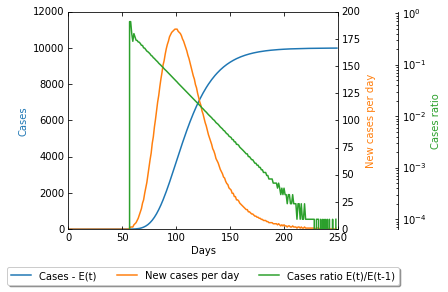

In [104]:
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA
import matplotlib.pyplot as plt

host = host_subplot(111, axes_class=AA.Axes)
plt.subplots_adjust(right=0.75)

par1 = host.twinx()
par2 = host.twinx()

new_fixed_axis = par2.get_grid_helper().new_fixed_axis
par2.axis["right"] = new_fixed_axis(loc="right",
                                    axes=par2,
                                    offset=(60, 0))

par1.axis["right"].toggle(all=True)

host.set_xlim(0, max_day)
# host.set_yscale('log')
host.set_ylim(0, 12000)

host.set_xlabel("Days")
host.set_ylabel("Cases")
par1.set_ylabel("New cases per day")
par1.set_ylim(top=200, bottom=0)
par2.set_ylabel("Cases ratio")
par2.set_yscale('log')

p1, = host.plot(days, cases, label="Cases - E(t)")
p2, = par1.plot(diff_days, diff, label="New cases per day")
p3, = par2.plot(diff_days, ratios, label="Cases ratio E(t)/E(t-1)")

host.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),
            fancybox=True, shadow=True, ncol=5)

host.axis["left"].label.set_color(p1.get_color())
par1.axis["right"].label.set_color(p2.get_color())
par2.axis["right"].label.set_color(p3.get_color())
plt.draw()

plt.show()

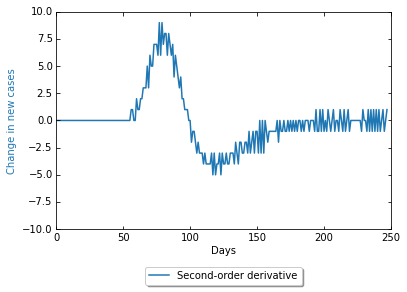

In [4]:
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA
import matplotlib.pyplot as plt

host = host_subplot(111, axes_class=AA.Axes)
host.set_xlim(0, max_day)
host.set_ylim(-10, 10)

host.set_xlabel("Days")
host.set_ylabel("Change in new cases")
p1, = host.plot(diff2_days, diff2, label="Second-order derivative")

host.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),
            fancybox=True, shadow=True, ncol=5)

host.axis["left"].label.set_color(p1.get_color())
plt.draw()
plt.show()

In [6]:
def window_peek(start, end, step=1):
    print(f"Window for {start} to {end} with step {step}:")
    window_slice = slice(start, end, step)
    print(f"Cases:")
    print(cases[window_slice])
    print(f"Ratios:")
    print(ratios[window_slice])
    print(f"Ratio exp:")
    print(np.exp(ratios[window_slice]))
    print(f"Diff:")
    print(diff[window_slice])

window_peek(57, 62)
print()
window_peek(100, 105)

Window for 57 to 62 with step 1:
Cases:
[1 2 4 6 8]
Ratios:
[0.69314718 0.69314718 0.40546511 0.28768207 0.40546511]
Ratio exp:
[2.         2.         1.5        1.33333333 1.5       ]
Diff:
[1 2 2 2 4]

Window for 100 to 105 with step 1:
Cases:
[3678 3862 4046 4228 4409]
Ratios:
[0.04881606 0.04654355 0.04400033 0.04191884 0.04001423]
Ratio exp:
[1.05002719 1.04764371 1.0449827  1.04280984 1.04082558]
Diff:
[184 184 182 181 180]


# Data

We used data sourced from the JHU CSSE COVID-19 Dataset.

Death time series data was used under the assumption that deaths are easier to track (harder to test everyone who gets infected, asymptomatics, etc.).

We chose to only examine the data from Hudson County, NJ under the logic that there's less chance of overlapping outbreaks at the county-level (plateauing). Also time-constrained as state total numbers require aggregating.

https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv

In [117]:
import pandas as pd
deaths = pd.read_csv('./deaths_covid19.csv')
deaths = deaths[deaths.Admin2 == 'Hudson']
# deaths.iloc[:,12:]
deaths.loc[:,'3/18/20':]

,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,...,6/5/20,6/6/20,6/7/20,6/8/20,6/9/20,6/10/20,6/11/20,6/12/20,6/13/20,6/14/20
1787,1,1,1,1,1,1,1,1,1,2,...,1205,1210,1218,1226,1235,1242,1242,1246,1253,1254


In [45]:
deaths

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,...,6/5/20,6/6/20,6/7/20,6/8/20,6/9/20,6/10/20,6/11/20,6/12/20,6/13/20,6/14/20
1787,84034017,US,USA,840,34017.0,Hudson,New Jersey,US,40.737662,-74.075157,...,1205,1210,1218,1226,1235,1242,1242,1246,1253,1254


In [ ]:
for index, header in enumerate(deaths.columns):
    if header[0].isnumeric():
        print(index, header)

In [110]:
cases = deaths.loc[:,'3/10/20':].to_numpy()[0]

In [118]:
import numpy as np
import matplotlib.pyplot as plt

def gompertz(n, k, t0, t):
    result = n * np.exp(-np.exp(-k * (t - t0)))
    if result > 1:
        return result
    else:
        return 1

max_day = 89
# discrete range of days (starting from 0 -> 250, step=1, exclusive?)
days = np.arange(0, max_day, 1)
# same range but without last element since discrete derivative doesn't exist for last value
# i.e. v[x+1] - v[x] only makes sense up to x_n where n=max_index-1
diff_days = np.arange(0, max_day-1, 1)
# excluded key allows for currying
# vgompertz = np.vectorize(gompertz, excluded=['n', 'k', 't0'])

# cases = vgompertz(10000, 0.05, 100, days)
cleaned_deaths = deaths.loc[:,'3/18/20':].rolling(window=5, axis=1, min_periods=0).mean()

cases = cleaned_deaths.to_numpy()[0]

# discrete derivative: v[x+1] - v[x] over [0, cases_count-2]
diff = np.diff(cases)

# clever logarithmic way to calculate something like np.diff
# but with ratio of next/previous instead of difference
ratios = np.diff(np.log(cases))

# prepare second-order derivative
diff2_days = np.arange(0, max_day-2, 1)
diff2 = np.diff(diff)

In [97]:
cleaned_deaths

,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,...,6/5/20,6/6/20,6/7/20,6/8/20,6/9/20,6/10/20,6/11/20,6/12/20,6/13/20,6/14/20
1787,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.2,...,1193.4,1198.8,1204.8,1211.6,1218.8,1226.2,1232.6,1238.2,1243.6,1247.4


In [98]:
cases

array([1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
       1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.2000e+00,
       1.8000e+00, 2.8000e+00, 4.0000e+00, 4.2000e+00, 9.6000e+00,
       1.7600e+01, 2.8200e+01, 4.2400e+01, 5.9400e+01, 7.2000e+01,
       8.3800e+01, 9.6400e+01, 1.0720e+02, 1.2240e+02, 1.4060e+02,
       1.6520e+02, 1.8800e+02, 2.1700e+02, 2.4680e+02, 2.8320e+02,
       3.2200e+02, 3.6160e+02, 4.2860e+02, 4.8860e+02, 5.4280e+02,
       5.9020e+02, 6.3660e+02, 6.5540e+02, 6.7420e+02, 6.7920e+02,
       6.8240e+02, 6.9360e+02, 7.0400e+02, 7.2240e+02, 7.5400e+02,
       7.8620e+02, 8.1080e+02, 8.2820e+02, 8.4260e+02, 8.5940e+02,
       8.7960e+02, 8.9960e+02, 9.2140e+02, 9.4120e+02, 9.5980e+02,
       9.7280e+02, 9.8520e+02, 1.0008e+03, 1.0154e+03, 1.0252e+03,
       1.0366e+03, 1.0488e+03, 1.0588e+03, 1.0716e+03, 1.0868e+03,
       1.1022e+03, 1.1162e+03, 1.1276e+03, 1.1338e+03, 1.1382e+03,
       1.1430e+03, 1.1476e+03, 1.1534e+03, 1.1606e+03, 1.1686e

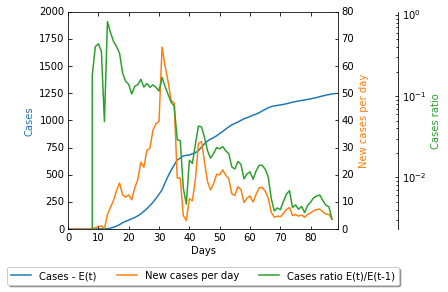

In [119]:
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA
import matplotlib.pyplot as plt

host = host_subplot(111, axes_class=AA.Axes)
plt.subplots_adjust(right=0.75)

par1 = host.twinx()
par2 = host.twinx()

new_fixed_axis = par2.get_grid_helper().new_fixed_axis
par2.axis["right"] = new_fixed_axis(loc="right",
                                    axes=par2,
                                    offset=(60, 0))

par1.axis["right"].toggle(all=True)

host.set_xlim(0, max_day)
# host.set_yscale('log')
host.set_ylim(0, 2000)

host.set_xlabel("Days")
host.set_ylabel("Cases")
par1.set_ylabel("New cases per day")
par1.set_ylim(top=80, bottom=0)
par2.set_ylabel("Cases ratio")
par2.set_yscale('log')

p1, = host.plot(days, cases, label="Cases - E(t)")
p2, = par1.plot(diff_days, diff, label="New cases per day")
p3, = par2.plot(diff_days, ratios, label="Cases ratio E(t)/E(t-1)")

host.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),
            fancybox=True, shadow=True, ncol=5)

host.axis["left"].label.set_color(p1.get_color())
par1.axis["right"].label.set_color(p2.get_color())
par2.axis["right"].label.set_color(p3.get_color())
plt.draw()

plt.show()